## Building a Spotify Recommender based on Listening History and Song Features
### Introduction
Based on my Spotify Wrapped for 2019, I accumulated 120,000+ minutes of listening which translates to over 2000 hours, which also translates to a whooping 83.3 days. So I do consider myself a huge music enthusiast and enjoy exploring all the different genres music has to offer. Because of my extensive listening history, I realized I had a lot of data to work with to **create a classifier that will state whether or not I would like to listen to a song or not.**

### About the Data 
We used two datasets in this project: "StreamingHistory.csv" (my Spotify listening history) and "SpotifyFeatures.csv" (dataset with song features). StreamingHistory.csv was obtained through Spotify with a json drop and SpotifyFeatures.csv was downloaded from kaggle. (https://tinyurl.com/y7mpts3e)

StreamingHistory.csv has 66,203 rows and 4 columns (Artist, Date, msPlayed, trackName). SpotifyFeatures.csv contains 223,044 rows and 17 columns. Of these 17 columns, 14 are related to a song's feautures such as popularity, mode, key, and etc. (Read more about the features here: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) Moreover, each row represents an individual song. 

### Goal
In this project, I will build a song recommender based on my personal Spotify listening history and a Spotify song features dataset. **To accomplish this, I will compare 3 classifier models: Logistic Regression, Decision Trees and Random Forest, and evaluate each model based on the F1 score. In addition, I will be able to discover which song features appeal to my song preferences more.** 

#### Why use F1 score? 
The F1 score enables us to take into account false negatives and false positives when calculating the accuracy of a model. If we use the generic accuracy_score method, false positives would be considered as correct predictions which is something that is inaccurate and would mislead me into thinking my model is more accurate than it is. 
#### What is a "favorite" song?
The variable that I will be predicting will be a binary feature with 0 representing "not a favorite" and 1 representing a favorite. I will create this binary feature through my personal listening history and label songs with more than 15 listens as a favorite and those with less as "not a favorite". Why 15? When I plotted the song counts on a histogram, there was a drop in song frequencies around 15. I concluded that this would be a good cut off as songs past the cut off were clearly less in number than those before. There most be something about those songs that create this cutoff. As a result, I would be able to hone in on the features that makes a song a favorite more. 

![favorite](favorite.png)

### Process
* Data Cleaning / Exploration 
* Balancing Classes with Oversampling (SMOTE) and Feature Selection
* Model Selection with Cross-validation and Hyperparameter Optimization
* Predicting Songs and Saving Dataset for Personal Use

### Project Value and Actionable Next Steps
This project will enable me to obtain a mass recommendation of songs at once instead of having to go through options such as Discover Weekly (limited to 30 songs), look through different playlists, or opt for a playlist radio. Moreover, with the recommendations generated from this project, I can automate playlist creations by converting the .csv recommendations file into a Spotify playlist, making it convenient for me to access new music instead of adding it manually song by song. Link to that script can be found here: https://github.com/isacmlee/csv-to-playlist.


### Conclusion / Results
Through this project, I was able to fit a Random Forest Tree Classifier with a F1 score of around 99%, confirmed through cross-validation as well as unseen test data. The Logistic Regression model had the lowest F1 score of 79% while the Decision Tree was close to the Random Forest Tree at 97%. 

I also discovered that the song features that had the most association with a favorite song of mine were popularity (+ association), danceability (+ association), and instrumentalness (- association). This finding indicates that my music taste is generally mainstream with good characteristics of a dance song but also with more focus on words. All these features appear to represent the Pop genre, which may indicate that is may favorite genre.

![correlation](corr.png)


With these features and a hyperparameterized Decision Tree model, I was able to recommend songs that I would favorite and create a playlist with these songs. 

# Code


### Data Cleaning / Exploration 

In [1]:
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE

In [2]:
# Read-in Personal Listening History
df = pd.read_csv("StreamingHistory.csv")
df.head()

,Unnamed: 0,artistName,endTime,msPlayed,trackName
0,0,Roy Woods,2018-12-18 21:44,77725,Down Girl
1,1,Drake,2018-12-19 01:27,1000,Marvins Room
2,2,Roy Woods,2018-12-19 01:27,2370,Down Girl
3,3,Sabrina Claudio,2018-12-19 01:32,214607,Too Much Too Late
4,4,Logic,2018-12-19 01:35,182266,44 Bars


In [3]:
# Dropping irrelevant columns 
df = df.drop('Unnamed: 0', axis=1)
# Renaming the column names
df = df.rename(columns={"artistName":"artist","endTime":"date","trackName":"track"})

I will define a favorite song as a song with 15 or more listens and create a new dataframe that contains only those songs.

**Why did we choose 15?**


As seen from the histogram below, the first major drop in song frequencies comes around 15. This enables me to eliminate many songs that may cause the model to be more complicated and also prevents me from taking into account songs that I may have accidently listened to on the radio instead of intentionally listening to it. 

Text(0.5, 1.0, "Choosing what is a 'favorite' song")

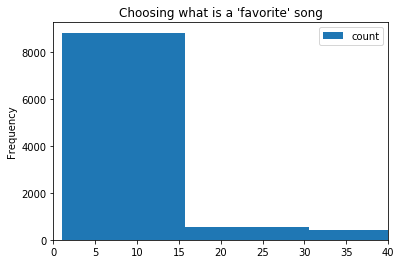

In [4]:
ax = df.groupby(['artist','track']).size().to_frame('count').reset_index().plot(kind='hist',bins=9)
ax.set_xlim(0,40)
ax.set_title("Choosing what is a 'favorite' song")

In [5]:
# Find number of occurences of each song, and keep songs with 15 or more listnes
df.groupby(['artist','track']).size().to_frame('count').reset_index()
df = df.groupby(['artist','track']).size().to_frame('count').reset_index()
df = df[df['count']>=15]
# To display the top 5 rows
df.head(5)

,artist,track,count
42,5 Seconds of Summer,Youngblood,20
50,6LACK,Ex Calling,25
57,6LACK,Pretty Little Fears (feat. J. Cole),77
58,6LACK,Seasons (feat. Khalid),70
72,88rising,Head In The Clouds,45


In [6]:
# Read-in Song Features dataset
features = pd.read_csv("SpotifyFeatures.csv")
# renaming columns
features = features.rename(columns={"artist_name":"artist","track_name":"track"})
features.head(5)

,genre,artist,track,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


The 'favorite' column will be the variable that I will try to predict.

In [7]:
# Create 'favorite' column (favorite = 1, not favorite = 0)
features['same_artists'] = features.artist.isin(df.artist) 
features['same_track'] = features.track.isin(df.track) 
features["favorite"] = np.where((features["same_artists"] == True) & (features["same_track"] == True),1,0) # If both instances are True.
features = features.drop(["same_artists","same_track"],axis=1)

In [8]:
# For future use
future = features.copy(deep=True)

In [9]:
# Genre 
features.genre.unique()

array(['Movie', 'R&B', 'A Capella', 'Alternative', 'Country', 'Dance',
       'Electronic', 'Anime', 'Folk', 'Blues', 'Opera', 'Hip-Hop',
       "Children's Music", 'Children’s Music', 'Rap', 'Indie',
       'Classical', 'Pop', 'Reggae', 'Reggaeton', 'Jazz', 'Rock', 'Ska',
       'Comedy', 'Soul', 'Soundtrack', 'World'], dtype=object)

In [10]:
features

,genre,artist,track,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,favorite
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61100,0.389,99373,0.910,0.000000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814,0
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.24600,0.590,137373,0.737,0.000000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816,0
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.95200,0.663,170267,0.131,0.000000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368,0
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.70300,0.240,152427,0.326,0.000000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227,0
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.95000,0.331,82625,0.225,0.123000,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4/4,0.962,0
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.03290,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969,0
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813,0
232723,Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.26200,0.745,222442,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489,0


Comedy stands out to me the most as I want to know if 'songs' in this genre are actually songs. 

In [11]:
features[features.genre == 'Comedy'].describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,favorite
count,9681.000000,9681.000000,9681.000000,9.681000e+03,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.0
mean,21.342630,0.793098,0.559038,2.353052e+05,0.676094,0.000574,0.724775,-11.689321,0.853532,98.235488,0.412764,0.0
std,8.428764,0.130313,0.089625,2.502539e+05,0.211705,0.009987,0.223437,4.777983,0.205918,27.839986,0.207258,0.0
min,0.000000,0.000363,0.239000,3.004000e+04,0.001410,0.000000,0.025800,-31.047000,0.023000,32.451000,0.023700,0.0
25%,15.000000,0.753000,0.499000,1.218800e+05,0.522000,0.000000,0.662000,-14.649000,0.888000,79.720000,0.252000,0.0
50%,20.000000,0.819000,0.561000,1.890570e+05,0.704000,0.000000,0.767000,-11.209000,0.928000,90.124000,0.410000,0.0
75%,26.000000,0.872000,0.620000,2.812930e+05,0.859000,0.000000,0.898000,-8.088000,0.944000,115.128000,0.561000,0.0
max,61.000000,0.995000,0.898000,5.552917e+06,0.998000,0.352000,0.996000,-0.255000,0.967000,207.157000,0.980000,0.0


From this chart, I can look at the values in instrumentalness, liveness, and speechiness to deduce that there are almost no instrumentals, the recording is highly probable to be in front of a live audience, and that it contains a lot words. As a result, I can conclude that the 'songs' in the comedy genre are snippets from comedy shows put on Spotify. Therefore, I will be removing all 'songs' from this genre because they do not accurately represent music and will distort the model with its features. 

In [12]:
# Removing 'songs' with these genres
features = features[features.genre!='Comedy']
# Track_id
features = features.drop(columns='track_id')

Since all track_ids are unique and track_id merely represents both artist and song name, I will not able to use this feature to predict a favorite song as it is repetitious. We can drop this feature.

In [13]:
features = features.drop(columns='track')

As more than half of the data in the 'track' columns are unique, I believe that there will be a very low correlation between 'track' and 'favorite'. I will also drop this column.

In [14]:
features.head(1)

,genre,artist,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,favorite
0,Movie,Henri Salvador,0,0.611,0.389,99373,0.91,0.0,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814,0


### Balancing Classes with Oversampling (SMOTE) and Feature Selection
Because my classes are heavily imbalanced, if I leave our data alone, my model will predict most songs as the majority class (in our case, 0). Therefore, I will use SMOTE to oversample from the minority class to balance them out.

**To prevent data leakage, it is important that you split your data first then apply SMOTE. However, because I want to show a correlation matrix, I am going to apply it on the entire dataset. When I train my model, I will split first.**

**Side note**: While I could undersample from our majority class, I will also lose a lot of data as the majority class overwhelms the minority. 

In [15]:
# How the classes are imbalanced
features.favorite.value_counts()

0    219815
1      3229
Name: favorite, dtype: int64

In [16]:
X = features.drop(columns=['favorite','genre','artist','key','mode','time_signature'])
y = features.favorite
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X['favorite'] = y

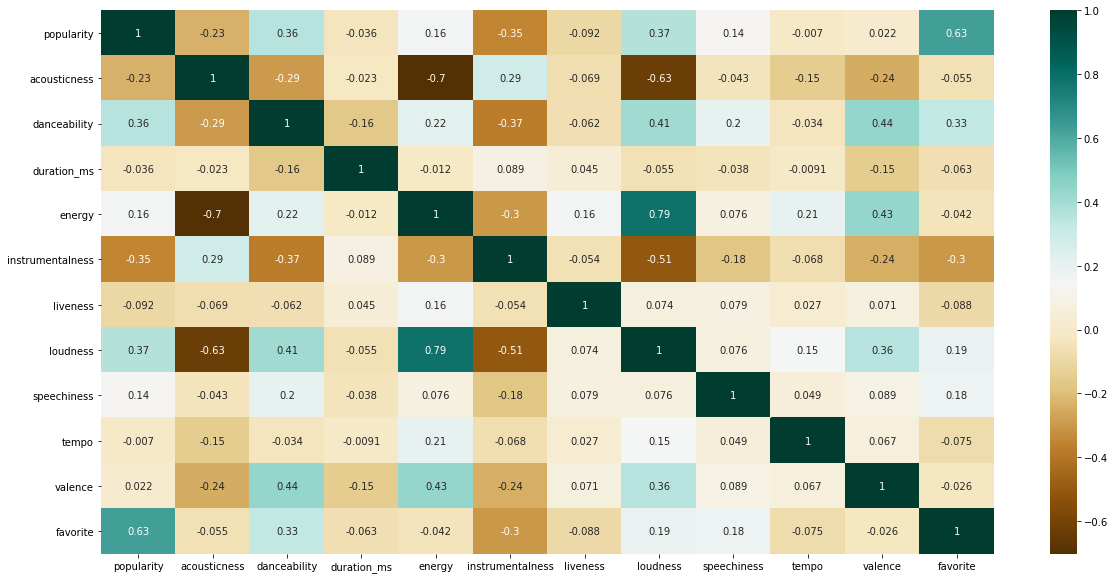

In [17]:
# Correlation Matrix of quantitative features
plt.figure(figsize=(20,10))
c = X.corr()
corr = sns.heatmap(c,cmap="BrBG",annot=True)

Of all the quantitative features, **popularity, danceability, and instrumentalness** have the highest associations, with popularity and danceability being positive and instrumentalness being negative. As a result, I will use these three features in my model.

### Model Selection with Cross-validation and Hyperparameter Optimization
Now, I want to be able to select which classifier algorithm I want to use for our problem. In order to do this, I will compare three algorithms: Random Forest Classifier, Decision Tree Classifier, and Logistic Regression. 

In [18]:
# Importing required libraries
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import f1_score
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier

In [19]:
# Train / Split Data
X_train, X_test, y_train, y_test = train_test_split(features.drop(columns='favorite'), features.favorite,test_size = .20)

In [20]:
X_train = X_train.drop(columns=['genre','artist','key','mode','time_signature'])

In [21]:
# Applying SMOTE 
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

For each model, I will use cross-validation to see how well each model generalizes and obtain a F1 score.

In [28]:
%%time
# Logistic Regression
lr = LogisticRegression()
lr_scores = cross_val_score(lr, X_train, y_train, cv=10, scoring="f1")
np.mean(lr_scores)

CPU times: user 26.4 s, sys: 803 ms, total: 27.2 s
Wall time: 14 s


0.7904689733827925

In [29]:
# Hyperparameter optimization for Decision Tree Classifier
parameters = {
    'max_depth':[15,20,30],
}
dtc = Pipeline([('CV',GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5))])
dtc.fit(X_train, y_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 30}

In [31]:
%%time
# Decision Tree
dt = DecisionTreeClassifier(max_depth=30)
dt_scores = cross_val_score(dt, X_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

CPU times: user 59.4 s, sys: 495 ms, total: 59.9 s
Wall time: 1min


0.9785300408107732

In [22]:
# Hyperparameter optimization of RandomForestClassifier
parameters = {
    'max_depth':[6,12,15,20],
    'n_estimators':[20,30]
}
clf = Pipeline([('CV',GridSearchCV(RandomForestClassifier(), parameters, cv = 5))])
clf.fit(X_train, y_train)
clf.named_steps['CV'].best_params_

{'max_depth': 20, 'n_estimators': 30}

In [23]:
%%time
# Cross-validation for RandomForestClassifier
rf = Pipeline([('rf', RandomForestClassifier(n_estimators = 20, max_depth = 30))])
rf_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="f1")
np.mean(rf_scores)

CPU times: user 4min 53s, sys: 6.08 s, total: 4min 59s
Wall time: 5min 6s


0.9917851082368905

### Predicting Songs and Saving Dataset for Personal Use

In [33]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=30)

In [34]:
y_pred = dt.predict(X_test.drop(columns=['genre','artist','key','mode','time_signature']))

In [35]:
prediction = dt.predict(future.drop(columns=['track','track_id','favorite','genre','artist','key','time_signature','mode']))

In [36]:
future['prediction'] = prediction

In [37]:
# Gets only songs that were not favorites but are predicted to be
future = future[(future['favorite']==0) & (future['prediction'] == 1)]

In [38]:
future = future.drop(columns=['track_id','energy','duration_ms','acousticness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence'])

In [39]:
future

,genre,artist,track,popularity,danceability,instrumentalness,favorite,prediction
138,R&B,Surfaces,Heaven Falls / Fall on Me,61,0.563,0.002430,0,1
139,R&B,Olivia O'Brien,Love Myself,68,0.653,0.000000,0,1
146,R&B,Beyoncé,Flawless Remix,69,0.639,0.000008,0,1
149,R&B,Big Sean,I Know,66,0.741,0.000000,0,1
152,R&B,Jessie Reyez,Body Count (feat. Normani & Kehlani) - Remix,62,0.703,0.000000,0,1
...,...,...,...,...,...,...,...,...
230844,Soul,Seinabo Sey,Younger - Bonus Track / Acoustic Version,53,0.479,0.000000,0,1
230914,Soul,Paolo Nutini,These Streets,52,0.721,0.000000,0,1
231246,Soul,LION BABE,Honey Dew,45,0.674,0.007340,0,1
231895,Soul,Sports,Shiggy,41,0.554,0.000224,0,1


In [218]:
# Saving csv
future.to_csv("recommendations.csv")

### Conclusions
After converting recommendations.csv into a Spoitfy playlist, I was able to browse and listen to the recommendations. Ultimately, I quite enjoyed the recommendations except for a couple "what?" reactions to a few songs here and there. 
You can test the model for yourself at [whatspopping.xyz](http://www.whatspopping.xyz/)! Let me know what you think. :)